# 2150188401(2) Artificial Intelligence Assignment #2-2<br> Training Vision Transformers (PyTorch)

Copyright (C) Computer Science & Engineering, Soongsil University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Haneul Pyeon, September 2024.

**For understanding of this work, please carefully look at given PDF file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn to understand and build the basic components of Vision Tranformer(ViT). Then, you will try to classify images in the FashionMNIST datatset and explore the effects of different components of ViTs.
<br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results. 

### Some helpful tutorials and references for assignment #2-2:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Alexey Dosovitskiy et al., "An Image is Worth 16 x 16 Words: Transformers for Image Recognition at Scale", ICLR 2021. [[pdf]](https://arxiv.org/pdf/2010.11929.pdf)

## 1. Building Vision Transformer
Here, you will build the basic components of Vision Transformer(ViT). <br>

![Vision Transformer](imgs/ViT.png)

Using the explanation and code provided as guidance, <br>
Define each component of ViT. <br>


#### ViT architecture:
* ViT model consists with input patch embedding, positional embeddings, transformer encoder, etc.
* Patch embedding
* Positional embeddings
* Transformer encoder with
    * Attention module
    * MLP module

In [1]:
import torch
import torch.nn as nn

##### Patch Embed

**Initialization**: When you create an instance of the PatchEmbedding class, you specify the image_size, patch_size, and in_channels. image_size is the height and width of the input image, patch_size is the size of each patch, and in_channels is the number of input image channels (e.g., 3 for RGB images). 

**Convolutional Projection**: Inside the PatchEmbedding class, a 2D convolutional layer (nn.Conv2d) is used to perform a patch-based projection. This convolutional layer has a kernel size of patch_size, which defines the size of each patch, and a stride of patch_size, which ensures that patches do not overlap. The convolutional layer effectively extracts image patches.

**Reshaping**: After the convolutional projection, the output tensor is reshaped using view. It is transformed from a 4D tensor with dimensions (batch_size, in_channels, H, W) to a 3D tensor with dimensions (batch_size, num_patches, patch_dim). num_patches is the total number of non-overlapping patches in the image, and patch_dim is the number of output channels from the convolutional layer.

In [2]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ##############################################################################

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size = patch_size, stride = patch_size)

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################
    def forward(self, x):
        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ##############################################################################

        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################
        return x # output dimension must be: (batch size, number of patches, embed_dim)

##### Attention

**Initialization**
* dim: The input dimension of the sequence. This is the dimensionality of the queries, keys, and values.
* num_heads: The number of attention heads to use. Multi-head attention allows the model to focus on different parts of the input simultaneously.

**Linear Projections (qkv and proj)**: The qkv linear layer takes the input sequence and projects it into three parts: queries (q), keys (k), and values (v). The output of this layer has a shape of (batch_size, sequence_length, 3 * dim).

**Forward Pass (forward method)**: In the forward pass, the input tensor x is processed through the attention mechanism. Here's what happens:<br>
* The linear projection qkv is applied to x, producing a tensor of shape (batch_size, sequence_length, 3 * dim).|
* This tensor is reshaped to have dimensions (batch_size, sequence_length, 3, num_heads, head_dim). The permute operation rearranges the dimensions to (3, batch_size, num_heads, sequence_length, head_dim), making it suitable for multi-head attention.
* The three parts, q, k, and v, are extracted from the reshaped tensor.
* The attention scores are computed by taking the dot product of queries q and keys k. The result is scaled by self.scale.
* The attention scores are passed through a softmax activation along the last dimension (sequence_length), producing attention weights.
* The weighted sum of values v is computed using the attention weights.
* The result is transposed and reshaped to its original shape, and then passed through the proj linear layer.
* The final output is returned.

In [3]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ##############################################################################

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv[:, :, 0], qkv[:, :, 1], qkv[:, :, 2]

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim = -1)

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################

        x = (attn @ v).transpose(1, 2).reshape(B, N, C) # Vector Matrix Multiply
        x = self.proj(x)
        
        return x # output dimension must be: (batch size, number of patches, embed_dim)

##### MLP

The MLP module must consist of three layers:
* fully conncted layer 1
* activation layer
* fully conncted layer 2

In [4]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ##############################################################################

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer() # GELU
        self.fc2 = nn.Linear(hidden_features, out_features)

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ##############################################################################

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################
        return x # output dimension must be: (batch size, number of patches, out_features)


##### Transformer Block
The transformer block contains the attention module and MLP module which have residual connections. 
Refer to the following image and build the forward pass.

![Transformer Block](imgs/TransformerBlock.png)

In [5]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer)

    def forward(self, x):
        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ##############################################################################

        # 1. Residual connection for "Attention"
        x = x + self.attn(self.norm1(x))

        # 2. Residual connection for MLP
        x = x + self.mlp(self.norm2(x))

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################
        return x


##### Vision Transformer

Using all the components that you built above, **complete** the vision transformer class.

### torch.cat

Concatenates the given sequence of tensors along the specified dimension. All tensors must either have the same shape (except in the concatenating dimension) or be a 1-D empty tensor with size (0,).

`torch.cat()` can be seen as an inverse operation for `torch.split()` and `torch.chunk()`.

`torch.cat()` can be best understood via examples.

#### Parameters

- **tensors** (sequence of Tensors): any Python sequence of tensors of the same type. Non-empty tensors provided must have the same shape, except in the concatenating dimension.

- **dim** (int, optional): the dimension over which the tensors are concatenated.

#### Keyword Arguments

- **out** (Tensor, optional): the output tensor.

In [6]:
# example
x = torch.randn(2, 3)
x

tensor([[ 0.5463,  0.3333,  0.3193],
        [ 0.7136, -1.1470, -0.6931]])

In [7]:
exam1 = torch.cat((x, x, x), 0)
exam1

tensor([[ 0.5463,  0.3333,  0.3193],
        [ 0.7136, -1.1470, -0.6931],
        [ 0.5463,  0.3333,  0.3193],
        [ 0.7136, -1.1470, -0.6931],
        [ 0.5463,  0.3333,  0.3193],
        [ 0.7136, -1.1470, -0.6931]])

In [8]:
exam2 = torch.cat((x, x, x), 1)
exam2

tensor([[ 0.5463,  0.3333,  0.3193,  0.5463,  0.3333,  0.3193,  0.5463,  0.3333,
          0.3193],
        [ 0.7136, -1.1470, -0.6931,  0.7136, -1.1470, -0.6931,  0.7136, -1.1470,
         -0.6931]])

In [9]:
class VisionTransformer(nn.Module):
    """ Vision Transformer """

    def __init__(self, img_size=28, patch_size=4, in_chans=1, num_classes=10, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., norm_layer=nn.LayerNorm, ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ############################################################################## 
        # similarly to cls_token, define a learnable positional embedding that matches the patchified input token size.
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,  norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(
            embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):
        ##############################################################################
        #                           IMPLEMENT YOUR CODE                              #
        ##############################################################################
        B = x.shape[0]
        
        # Patch Embedding
        x = self.patch_embed(x)
        
        # Concatenate class tokens to patch embedding
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim = 1)

        # Add positional embedding to patches
        x = x + self.pos_embed 

        # Forward through encoder blocks
        for blk in self.blocks:
            x = blk(x)

        # Use class token for classification
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Shape: (B, embed_dim)

        # Classifier head
        x = self.head(cls_token_final)  # Shape: (B, num_classes)

        ##############################################################################
        #                              END YOUR CODE                                 #
        ##############################################################################
        return x

## 2. Training a small ViT model on FashionMNIST dataset.

Define and Train a vision transformer on FashionMNIST dataset. **(You must reach above 85% for full points.)** <br>
Train with at least 5 different hyperparameter settings varying the following ViT hyperparameters. 
Report the setting for the best performance.

#### ViT hyperparameters:
* patch_size
* embed_dim
* depth
* num_heads
* mlp_ratio
* etc.


In [12]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import FashionMNIST

Using device:  cpu 


Training:   4%|▍         | 1/25 [03:01<1:12:27, 181.16s/it]

Epoch 1/25 loss: 0.75
New best model at epoch 1 with loss 0.7539


Training:   8%|▊         | 2/25 [06:06<1:10:26, 183.75s/it]

Epoch 2/25 loss: 0.47
New best model at epoch 2 with loss 0.4715


Training:  12%|█▏        | 3/25 [09:15<1:08:14, 186.11s/it]

Epoch 3/25 loss: 0.42
New best model at epoch 3 with loss 0.4187


Training:  16%|█▌        | 4/25 [12:26<1:05:50, 188.10s/it]

Epoch 4/25 loss: 0.39
New best model at epoch 4 with loss 0.3879


Training:  20%|██        | 5/25 [15:36<1:02:52, 188.62s/it]

Epoch 5/25 loss: 0.37
New best model at epoch 5 with loss 0.3700


Training:  24%|██▍       | 6/25 [18:52<1:00:35, 191.33s/it]

Epoch 6/25 loss: 0.36
New best model at epoch 6 with loss 0.3557


Training:  28%|██▊       | 7/25 [22:09<57:54, 193.05s/it]  

Epoch 7/25 loss: 0.34
New best model at epoch 7 with loss 0.3435


Training:  32%|███▏      | 8/25 [25:47<56:57, 201.04s/it]

Epoch 8/25 loss: 0.34
New best model at epoch 8 with loss 0.3390


Training:  36%|███▌      | 9/25 [29:38<56:04, 210.30s/it]

Epoch 9/25 loss: 0.34
New best model at epoch 9 with loss 0.3359


Training:  40%|████      | 10/25 [33:48<55:40, 222.72s/it]

Epoch 10/25 loss: 0.33
New best model at epoch 10 with loss 0.3285


Training:  44%|████▍     | 11/25 [37:24<51:25, 220.43s/it]

Epoch 11/25 loss: 0.32
New best model at epoch 11 with loss 0.3227


Training:  48%|████▊     | 12/25 [41:12<48:18, 222.96s/it]

Epoch 12/25 loss: 0.32
New best model at epoch 12 with loss 0.3187


Training:  52%|█████▏    | 13/25 [44:57<44:40, 223.35s/it]

Epoch 13/25 loss: 0.31
New best model at epoch 13 with loss 0.3108


Training:  56%|█████▌    | 14/25 [48:40<40:56, 223.28s/it]

Epoch 14/25 loss: 0.31
New best model at epoch 14 with loss 0.3085


Training:  60%|██████    | 15/25 [52:16<36:52, 221.22s/it]

Epoch 15/25 loss: 0.31
New best model at epoch 15 with loss 0.3052


Training:  64%|██████▍   | 16/25 [55:52<32:55, 219.55s/it]

Epoch 16/25 loss: 0.29
New best model at epoch 16 with loss 0.2929


Training:  68%|██████▊   | 17/25 [59:26<29:02, 217.87s/it]

Epoch 17/25 loss: 0.29
New best model at epoch 17 with loss 0.2852


Training:  72%|███████▏  | 18/25 [1:02:53<25:03, 214.75s/it]

Epoch 18/25 loss: 0.29
No improvement in loss for 1 epochs.


Training:  76%|███████▌  | 19/25 [1:06:14<21:03, 210.51s/it]

Epoch 19/25 loss: 0.28
New best model at epoch 19 with loss 0.2817


Training:  80%|████████  | 20/25 [1:09:40<17:25, 209.20s/it]

Epoch 20/25 loss: 0.28
New best model at epoch 20 with loss 0.2764


Training:  84%|████████▍ | 21/25 [1:13:20<14:10, 212.52s/it]

Epoch 21/25 loss: 0.28
No improvement in loss for 1 epochs.


Training:  88%|████████▊ | 22/25 [1:17:18<11:00, 220.03s/it]

Epoch 22/25 loss: 0.27
New best model at epoch 22 with loss 0.2719


Training:  92%|█████████▏| 23/25 [1:21:11<07:27, 223.87s/it]

Epoch 23/25 loss: 0.27
New best model at epoch 23 with loss 0.2678


Training:  96%|█████████▌| 24/25 [1:24:50<03:42, 222.66s/it]

Epoch 24/25 loss: 0.26
New best model at epoch 24 with loss 0.2622


Training: 100%|██████████| 25/25 [1:28:29<00:00, 212.40s/it]


Epoch 25/25 loss: 0.26
New best model at epoch 25 with loss 0.2558
Best model saved with loss 0.2558


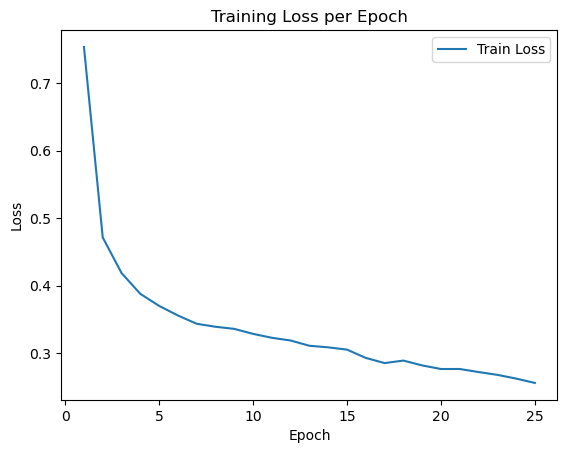

Testing: 100%|██████████| 79/79 [00:13<00:00,  5.68it/s]

Test loss: 0.36
Test accuracy: 86.71%
Training complete.


In [13]:
def Train():
    ##############################################################################
    #                           IMPLEMENT YOUR CODE                              #
    ##############################################################################

    patch_size = 8
    embed_dim = 360
    depth = 8
    num_heads = 12 # make sure embed_dim is divisible by num_heads!
    mlp_ratio = 4.0

    ##############################################################################
    #                              END YOUR CODE                                 #
    ##############################################################################

    # Loading data
    transform = ToTensor()

    train_set = FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_set = FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = VisionTransformer(patch_size=patch_size, embed_dim=embed_dim, depth=depth, num_heads=num_heads, mlp_ratio=mlp_ratio).to(device)
    model_path = './vit.pth'
    N_EPOCHS = 25
    LR = 0.0005
    early_stopping_patience = 3  # Early stopping patience (number of epochs with no improvement)
    min_loss = np.inf
    patience_counter = 0
    train_loss_history = []  # To store train losses for graph
    best_model_state = None

    # Training loop
    optimizer = AdamW(model.parameters(), lr = LR, weight_decay = 5e-3)
    criterion = CrossEntropyLoss()

    for epoch in trange(N_EPOCHS, desc="Training"):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_history.append(train_loss)
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

        # Early stopping check
        if train_loss < min_loss:
            min_loss = train_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            print(f'New best model at epoch {epoch + 1} with loss {min_loss:.4f}')
        else:
            patience_counter += 1
            print(f'No improvement in loss for {patience_counter} epochs.')

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Save the best model after training
    if best_model_state is not None:
        torch.save(best_model_state, model_path)
        print(f'Best model saved with loss {min_loss:.4f}')

    # Plotting the training loss
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.show()

    # Test loop
    model.load_state_dict(torch.load(model_path))  # Load the best model before testing
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

    print('Training complete.')

Train()

### Describe what you did and discovered here
In this cell you should write all the settings tried and performances you obtained. Report what you did and what you discovered from the trials.
You can write in Korean and English

## Trial 1
### Hyperparameters Setting
- patch_size : 8
- embed_dim : 360
- depth : 8
- num_heads : 12
- mlp_ratio : 4.0

### Results
- Training time : about 88 min.
- Test loss : 0.36
- Test accuracy : 86.71%


### P.S.
Due to the unavailability of GPU (CPU usage) in my local environment, please understand that I am attaching a model that was trained only once with the hyperparameter settings shown in the source code above in the local environment.